## COMP 551 Project 1: Analyzing COVID-19 Search Trends and Hospitalization

Zhangyuan Nie - 260924723,	Linghui Huang - 260831346,	Chen Hu - 260859053

In [462]:
!pip install kneed
from kneed import KneeLocator
import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import colors

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, neighbors
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as mae

%matplotlib inline

pd.options.display.max_rows = 10
np.random.seed(42)

'done'

'done'


# Task 1

## Download the datasets

In [463]:
# search trend dataset accessed on 2020-10-07 20:30 UTC
dataset1_url = 'https://raw.githubusercontent.com/google-research/open-covid-19-data/c0e599a49e27d8f418e90b8a29d740dccffe6c74/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv'
# hospitalization dataset as of 2020-10-06 16:23 UTC
dataset2_url = 'https://raw.githubusercontent.com/google-research/open-covid-19-data/c0e599a49e27d8f418e90b8a29d740dccffe6c74/data/exports/cc_by/aggregated_cc_by.csv'

# population data
# https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
pop_url = 'http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv'

## Load and clean the datasets

### Search Trends dataset

Prepare the dataframe for search trend data

In [464]:
df1 = pd.read_csv(dataset1_url, low_memory=False) # 608x430, weekly

# have a dictionary of region_code <-> region_name
region_map = df1[['open_covid_region_code', 'sub_region_1']].copy()
region_map.drop_duplicates(inplace=True)
region_map.set_index('open_covid_region_code', inplace=True)
region_map = region_map.to_dict()['sub_region_1']

# Drop useless columns
df1.drop(columns=['country_region_code',
                  'country_region',
                  'sub_region_1_code',
                  'sub_region_1'], inplace=True)

# Drop columns with > 50% NaN
df1 = df1.dropna(axis = 1, thresh=len(df1)*0.5) # 608x26

Normalize it with state population



In [465]:
def normalize_search_pop(df):
  pop_df = pd.read_csv(pop_url, low_memory=False)
  pop_df = pop_df[['NAME', 'POPESTIMATE2019']]
  pop_df = pop_df.set_index('NAME')
  # have a dictionary of region_name <-> pop
  pop_map = pop_df.to_dict()['POPESTIMATE2019']

  ret_df = df.copy()

  for (col_name, _) in ret_df.iteritems():
    if col_name.startswith('symptom:'):
        for idx, row in ret_df.iterrows():
          pop = pop_map[region_map[row['open_covid_region_code']]]
          ret_df.at[idx, col_name] = row[col_name] * pop
  return ret_df

df1 = normalize_search_pop(df1)

print("Search trend data shape: ", df1.shape)

Search trend data shape:  (608, 26)


### COVID hospitalization cases dataset

In [466]:
df2 = pd.read_csv(dataset2_url, low_memory=False) # 97644x62, daily
# get US regions
df2 = df2.loc[df2['open_covid_region_code'].isin(df1['open_covid_region_code'])].reset_index()
# Drop columns with all NaN
df2 = df2.dropna(axis = 1, how='all')
# Keep regions with valid hospitalized data
df2 = df2.groupby('open_covid_region_code').filter(lambda x: x['hospitalized_new'].sum() > 0).reset_index(drop=True).drop(columns='index') # 2355x5

# complete the dictionary of region_code <-> region_name
region_map.update(
    df2[['open_covid_region_code', 'region_name']]
    .copy().drop_duplicates().set_index('open_covid_region_code').to_dict()['region_name']
)

# convert into weekly
df2['date'] = df2['date'].astype('datetime64[ns]')
df2 = df2.groupby('open_covid_region_code').resample('W-Mon', on='date').sum().reset_index() # 342x4

# remove data after 09-21 to match search trend dataset
d0921 = np.datetime64('2020-09-21')
df2 = df2[df2.date < d0921]

print("Hospitalization data shape: ", df2.shape)

Hospitalization data shape:  (309, 4)


## Merge the two datasets

In [467]:
df1['date'] = df1['date'].astype('datetime64[ns]')

# outer since it appears that it is not necessary for a region to have both search and hospitalization data
df = df2.merge(df1, on=['open_covid_region_code','date'], how = 'outer')

# replace open_covid_region_code by region_name
df['open_covid_region_code'] = df['open_covid_region_code'].apply(lambda x: region_map[x])
df.rename(columns={"open_covid_region_code": "region_name"}, inplace=True)
df.sort_values(by=['region_name'])
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

print("Merged dataset shape: ", df.shape)

Merged dataset shape:  (608, 28)


# Task 2

### Distribution of search frequency

In [468]:
# function that returns a new dataframe with date and region as columns
# where each region column's value are the symptom's search frequency
def get_df_of_symptom(symptom):
  local_df = df[['date']].copy()
  local_df.drop_duplicates(inplace=True)
  local_df.sort_values(by=['date'], inplace=True)
  local_df.reset_index(drop=True, inplace=True)

  for _, row in df.iterrows():
    index = local_df[local_df['date'] == row['date']].index.values[0]
    local_df.at[index, row['region_name']] = row[symptom]

  # drop region with > 80% NaN
  local_df = local_df.dropna(axis = 1, thresh=len(local_df)*0.2)
  return local_df

In [469]:
# function that plots the distribution of search frequency, aggregated over all
# counties for a given symptom
def plot_symptom(symptom : str, figsize=(18,9)):
  symptom_df = get_df_of_symptom(symptom)

  local_df = symptom_df[['date']].copy()
  local_df['smaller']=0
  local_df['small']=0
  local_df['average']=0
  local_df['big']=0
  local_df['bigger']=0

  for (col_name, col) in symptom_df.iteritems():
    if col_name == 'date':
      continue
    mean = col.quantile(0.5)
    upper_mean = col.quantile(0.9)
    lower_mean = col.quantile(0.1)
    for i, row in symptom_df.iterrows():
      val = symptom_df.at[i, col_name]
      if val > upper_mean:
        local_df.at[i, 'bigger'] += 1
      elif val > mean:
        local_df.at[i, 'big'] += 1
      elif val > lower_mean:
        local_df.at[i, 'small'] += 1
      elif val <= lower_mean:
        local_df.at[i, 'smaller'] += 1
      else:
        local_df.at[i, 'average'] += 1

  ax = local_df.plot.bar(x='date', stacked=True, figsize=figsize,
                    color=['#73b359','#cdebb0','#ededed','#f2cee5','#c74294'],
                    title=symptom.replace('symptom:',''),
                    legend=False)
  ax.set_ylabel("Number of counties")
  ax.xaxis_date()

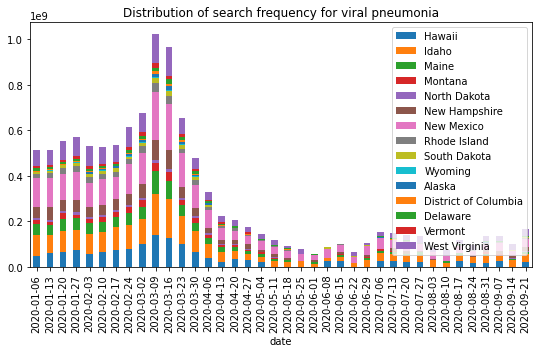

In [470]:
get_df_of_symptom('symptom:Viral pneumonia').plot.bar(x='date', stacked=True, figsize=(9,4.5))
plt.title('Distribution of search frequency for viral pneumonia')
plt.show()

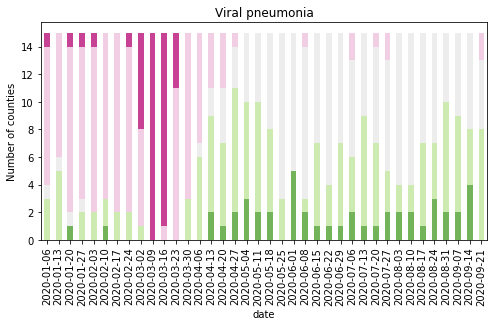

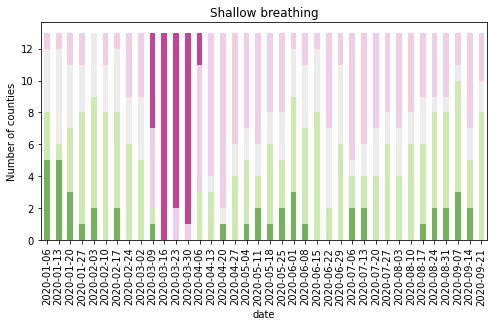

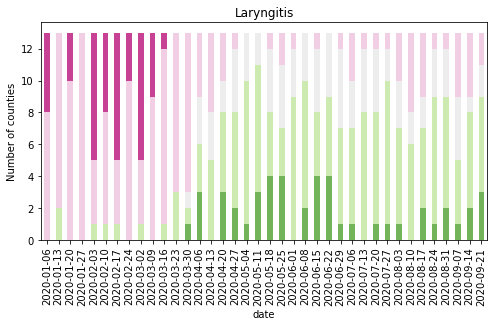

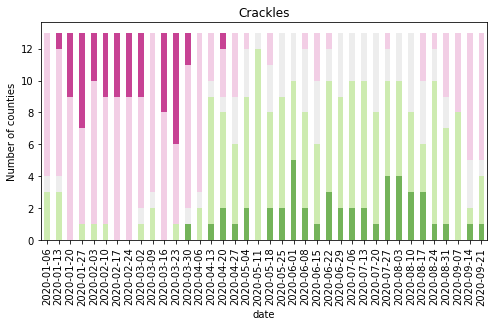

In [471]:
plot_symptom('symptom:Viral pneumonia', figsize=(8,4))
plot_symptom('symptom:Shallow breathing', figsize=(8,4))
plot_symptom('symptom:Laryngitis', figsize=(8,4))
plot_symptom('symptom:Crackles', figsize=(8,4))

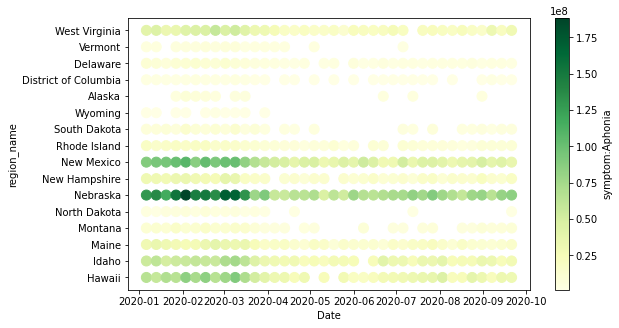

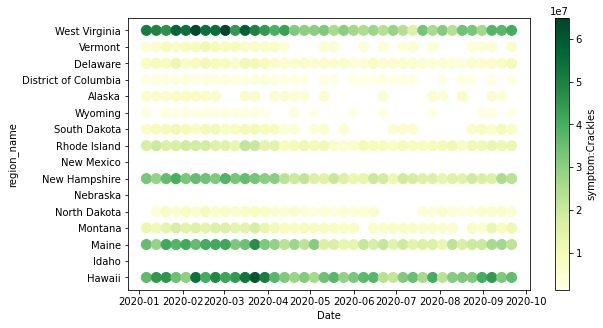

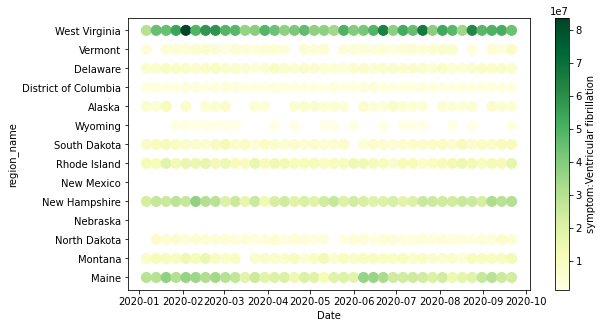

In [472]:
df['date'] = df['date'].astype('datetime64[ns]')
cols = {}
for (col_name, col) in df.iteritems():
  if col_name.startswith('symptom:'):
    cols[col_name] = col.isna().sum()
cols = sorted(cols, key=cols.get)

# plot the top 3
for i in range(3):
  fig, ax = plt.subplots()
  ax = df.plot.scatter(x='date', y='region_name', c=cols[i], cmap='YlGn', s=100, figsize=(9,5), ax=ax)
  ax.set_xlabel("Date")
  ax.xaxis.get_label().set_visible(True)

 ### Lower dimensional space using PCA

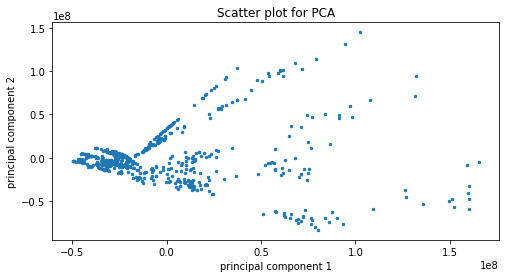

In [473]:
df['date'] = df['date'].astype('datetime64[ns]')
pca = PCA(n_components=5)
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

# the features with NaN replaced by the median
X = imp_median.fit_transform(df.drop(columns=['region_name', 'date', 'hospitalized_new',	'hospitalized_cumulative']))
Y = X # save original data for use in next step clustering

X = pca.fit_transform(X)
pca_df = pd.DataFrame(data = X[:,:2], columns = ['principal component 1', 'principal component 2'])

ax = pca_df.plot.scatter(x='principal component 1', y='principal component 2', figsize=(8,4), s=6, title="Scatter plot for PCA")


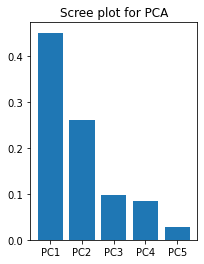

In [474]:
# scree plot of PCA
plt.figure(figsize=(3,4))
plt.bar(x=['PC1','PC2','PC3','PC4','PC5'], height=pca.explained_variance_ratio_)
plt.title("Scree plot for PCA")
plt.show()

### K-means Clustering

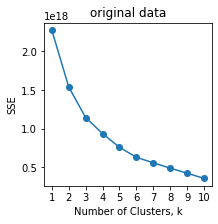

(For original data) Use elbow point: k = 3


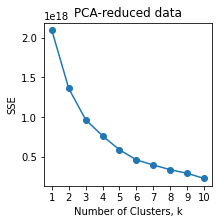

(For PCA-reduced data) Use elbow point: k = 3


In [475]:
# first determine k using the Elbow method: Calculate Within-Cluster-Sum of Squared Errors (WSS) for different values of k, 
# and choose the k for which WSS first starts to diminish
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(Y) # original data
  sse.append(kmeans.inertia_)

plt.figure(figsize=(3,3))
plt.plot(range(1, 11), sse, 'o-')
plt.title('original data')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters, k")
plt.ylabel("SSE")
plt.show()

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
k = kl.elbow
print('(For original data) Use elbow point: k =', k)

sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X) # PCA-reduced data
  sse.append(kmeans.inertia_)

plt.figure(figsize=(3,3))
plt.plot(range(1, 11), sse, 'o-')
plt.title('PCA-reduced data')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters, k")
plt.ylabel("SSE")
plt.show()

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
k = kl.elbow
print('(For PCA-reduced data) Use elbow point: k =', k)

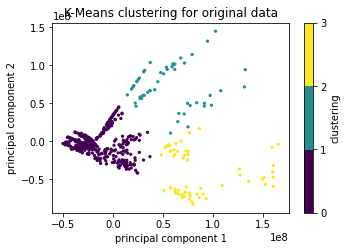

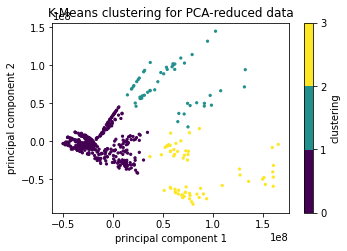

In [476]:
# original data
kmeans_high = KMeans(n_clusters=k, random_state=0)
kmeans_high.fit(Y)
y_pred_high = kmeans_high.predict(Y)

# PCA-reduced data
kmeans_low = KMeans(n_clusters=k, random_state=0)
kmeans_low.fit(X)
y_pred_low = kmeans_low.predict(X)

cmap = plt.cm.get_cmap('viridis')
norm = colors.BoundaryNorm(np.arange(0,k+1), cmap.N)

# plot the predictions
plt.figure(figsize=(5.3,3.5))
plt.scatter(X[:,0], X[:,1], c=y_pred_high, cmap=cmap, norm=norm, s=5)
plt.colorbar(ticks=np.arange(0,k+1), label='clustering')
plt.clim(-0.5,k+0.5)
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.title("K-Means clustering for original data")

plt.figure(figsize=(5.3,3.5))
plt.scatter(X[:,0], X[:,1], c=y_pred_low, cmap=cmap, norm=norm, s=5)
plt.colorbar(ticks=np.arange(0,k+1), label='clustering')
plt.clim(-0.5,k+0.5)
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.title("K-Means clustering for PCA-reduced data")
plt.show()

# Task 3

##Split dataset

Load the dataset

In [477]:
# keep only the regions with both valid search trends data and hospitalization data
df = df.groupby('region_name').filter(lambda x: x['hospitalized_new'].sum() > 0).reset_index(drop=True)

# load the dataset, replace NaN by median for search trends
x = imp_median.fit_transform(df.iloc[:,4:])
y = df.iloc[:,3].fillna(0) # fill na by 0 for hospitalization data

(num_instances, num_features), num_classes = x.shape, np.max(y)+1
print(num_instances, num_features, num_classes)

# define a function for the MSE loss
# loss = lambda y, yh: np.mean((y-yh)**2)
# we will use mae instead
errFigSize=(5,3)

418 24 22632.0


KNN cross validation of splitting by region

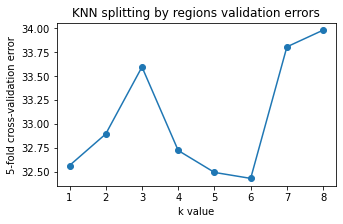

Minimal KNN 5-fold cross-validation error:  32.42836257309941 ( k = 6 )


In [478]:
# split by region
# drop unrelated columns form the dataframe
x1 = df.iloc[:,4:].fillna(df.median())
y1 = df.iloc[::,:3].fillna(0)
y1 = y1.iloc[:,-1:]

# for different K values, get a list of cross validation errors with 5-folds for different k values
err_val = []
minerr_KNN = 10000
k_min = 0
for K in range(1,9):
  #we store all regions in to a list
  region = df['region_name'].unique()
  #count the numbers for different region names
  number = region.shape[0]
  n_folds = 5
  p = round(number/n_folds) 
  err_valid = []
  err_valid_mse = []
  #loop for 5 different folds
  for i in range(n_folds):
    #create empty dataframe as x validation set and y validation set
    x_val = pd.DataFrame()
    y_val = pd.DataFrame()
    #initialize x train and y train set as x1 and y1
    x_tr = x1
    y_tr = y1
    inds =[i*p, i*p+1, i*p+2] 
    #loop for regions in the same fold
    for j in inds:        
      L = df.index[df['region_name']==region[j]]
      for k in L:
        #load the required row
        rowX = x1.iloc[k]
        rowY = y1.iloc[k]
        x_val = x_val.append(rowX)
        y_val = y_val.append(rowY)
        x_tr = x_tr.drop(k)
        y_tr = y_tr.drop(k)

    x_val = x_val.to_numpy()
    y_val = y_val.values.flatten()
    x_tr = x_tr.to_numpy()
    y_tr = y_tr.values.flatten()

    #use KNN model
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    #train the model
    model = model.fit(x_tr, y_tr)
    #get the MAE
    err_valid.append(mae(model.predict(x_val), y_val))

  if np.mean(err_valid) < minerr_KNN:
    minerr_KNN = np.mean(err_valid)
    k_min = K
  # print(err_valid)
  # print("K =", K, ": cross validation error", np.mean(err_valid))
  err_val.append(np.mean(err_valid))
  
plt.figure(figsize=errFigSize)
plt.plot(range(1,len(err_val)+1), err_val, '-o')
plt.title('KNN splitting by regions validation errors')
plt.xlabel('k value')
plt.ylabel('5-fold cross-validation error')
plt.show()

print("Minimal KNN 5-fold cross-validation error: ",minerr_KNN,"( k =",k_min,")")

split by date

In [479]:
#load the dataset
dataset = df.copy()
#data features include all symptoms (exclude the first 4 columns)
x1 = dataset.iloc[:,4:].fillna(dataset.median())
y1 = dataset.iloc[::,:3]
y1 = y1.iloc[:,-1:].fillna(0)

#split into train, validation sets by time (2020-08-10)
def split_byTime(x,y,dataset):
  x_valid = pd.DataFrame()
  y_valid = pd.DataFrame()
  x_train = x
  y_train = y
  d1 = datetime.date(2020, 8, 10) 
  for i in range(len(dataset)):
    #load the date for each i 
    p = dataset.loc[i,"date"]
    if p.date() > d1:
      entryX = x.iloc[i]
      entryY = y.iloc[i]
      x_valid = x_valid.append(entryX)
      y_valid = y_valid.append(entryY)
      x_train = x_train.drop(i)
      y_train = y_train.drop(i)

  return x_valid.to_numpy(), y_valid.values.flatten(), x_train.to_numpy(), y_train.values.flatten()

##Compare KNN with Decision Tree

Using KNN to train the data splitting by date

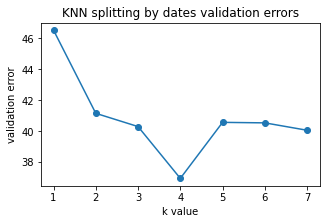

Minimal KNN validation error:  36.94318181818182 ( k = 4 )


In [480]:
x_valid, y_valid, x_train, y_train = split_byTime(x1,y1, dataset)
K_list = range(1,8)
err_valid = []
for i, K in enumerate(K_list):
  model = neighbors.KNeighborsRegressor(n_neighbors=K)
  model = model.fit(x_train, y_train)
  err_valid.append(mae(model.predict(x_valid), y_valid))
    
# print("KNN splitting by date validation error: ", err_valid)
plt.figure(figsize=errFigSize)
plt.plot(range(1,len(err_valid)+1), err_valid, '-o')
plt.title('KNN splitting by dates validation errors')
plt.xlabel('k value')
plt.ylabel('validation error')
plt.show()

print("Minimal KNN validation error: ",min(err_valid),"( k =",(err_valid.index(min(err_valid))+1),")")

Decision tree splitting by date

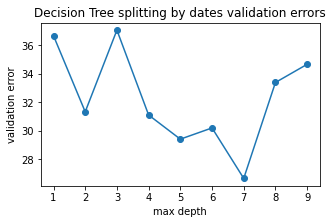

Minimal KNN validation error:  26.652162024653446 ( k = 7 )


In [481]:
err_valid = []
for a in range(1,10):
  tree = DecisionTreeRegressor(random_state=0, max_depth=a)
  probs_test = tree.fit(x_train, y_train).predict(x_valid)
  err = mae(tree.predict(x_valid), y_valid)
  # print("Decision Tree splitting by date ( max_depth =",a,") validation error: ", err)
  err_valid.append(err)

plt.figure(figsize=errFigSize)
plt.plot(range(1,len(err_valid)+1), err_valid, '-o')
plt.title('Decision Tree splitting by dates validation errors')
plt.xticks(range(1,len(err_valid)+1))
plt.xlabel('max depth')
plt.ylabel('validation error')
plt.show()

print("Minimal KNN validation error: ",min(err_valid),"( k =",(err_valid.index(min(err_valid))+1),")")

Decision tree splitting by regions

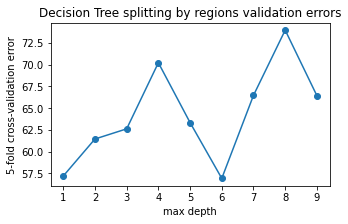

Minimal Decision tree validation error:  56.90497782360362 ( max depth = 6 )


In [482]:
minerr_tree = 100000
a_min = 0
err_val = []
for a in range(1,10):
  region = df['region_name'].unique()
  number = region.shape[0]
  n_folds = 5
  p = round(number/n_folds) 
  err_valid = []
  for i in range(n_folds):
    x_val = pd.DataFrame()
    y_val = pd.DataFrame()
    x_tr = x1
    y_tr = y1
    inds =[i*p, i*p+1, i*p+2] 
    for j in inds:        
      L = dataset.index[dataset['region_name']==region[j]]
      for k in L:
        #load the required row
        rowX = x1.iloc[k]
        rowY = y1.iloc[k]
        x_val = x_val.append(rowX)
        y_val = y_val.append(rowY)
        x_tr = x_tr.drop(k)
        y_tr = y_tr.drop(k)

    x_val = x_val.to_numpy()
    y_val = y_val.values.flatten()
    x_tr = x_tr.to_numpy()
    y_tr = y_tr.values.flatten()

    #use decision model
    model = DecisionTreeRegressor(random_state=0, max_depth=a)
    #train the model
    model = model.fit(x_tr, y_tr)
    #get the MAE
    err_valid.append(mae(model.predict(x_val), y_val))

  if np.mean(err_valid) < minerr_tree:
    minerr_tree = np.mean(err_valid)
    a_min = a
  # print(err_valid)
  # print("Decision Tree splotting by regions ( max_depth =",a,") validation error: ", np.mean(err_valid))
  err_val.append(np.mean(err_valid))

plt.figure(figsize=errFigSize)
plt.plot(range(1,len(err_val)+1), err_val, '-o')
plt.title('Decision Tree splitting by regions validation errors')
plt.xticks(range(1,len(err_val)+1))
plt.xlabel('max depth')
plt.ylabel('5-fold cross-validation error')
plt.show()

print("Minimal Decision tree validation error: ",minerr_tree,"( max depth =",a_min,")")

Learn separate models (KNN, Decision Tree) for each region (split by date)

In [483]:
regions = df['region_name'].unique()
k = 0
a = 0
minerr_KNN = 10000
minerr_tree = 10000
for ka in range(1,10):
  err_KNN = []
  err_tree = []
  for i in regions:
    b = df[df['region_name']==i].reset_index(drop=True)
    x1 = b.iloc[:,4:].fillna(df.median())
    y1 = b.iloc[::,:3].fillna(0)
    y1 = y1.iloc[:,-1:]
    ind1 = np.array(list(range(round(b.shape[0]*0.8))))
    ind2 = np.array(list(range(round(b.shape[0]*0.8),b.shape[0])))
    x_val, y_val, x_tr, y_tr = split_byTime(x1,y1,b)

    model = neighbors.KNeighborsRegressor(n_neighbors=ka)
    model = model.fit(x_tr, y_tr)
    err = mae(model.predict(x_val), y_val)
    err_KNN.append(err)     
    # print(i, err)

    tree = DecisionTreeRegressor(random_state=0, max_depth=ka)
    probs_test = tree.fit(x_tr, y_tr).predict(x_val)
    err_t = mae(tree.predict(x_val), y_val)
    err_tree.append(err_t)
    # print(i, err_t)

  if np.mean(err_KNN) < minerr_KNN:
    minerr_KNN = np.mean(err_KNN)
    k = ka
  if np.mean(err_tree) < minerr_tree:
    minerr_tree = np.mean(err_tree)
    a = ka
  # print("KNN ( k =",ka,") mean validation error: ",np.mean(err_KNN))
  # print("Decision tree ( max_depth =",ka,") mean validation error: ",np.mean(err_tree))

print("Minimal KNN mean validation error: ",minerr_KNN,"( k =",k,")")
print("Minimal Decision tree mean validation error: ",minerr_tree,"( max depth =",a,")")

Minimal KNN mean validation error:  39.553030303030305 ( k = 2 )
Minimal Decision tree mean validation error:  33.438131313131315 ( max depth = 5 )
